<a href="https://colab.research.google.com/github/muhammadtarek98/CNN-with-sequence-dataset/blob/main/VideoDataGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow

     |████████████████████████████████| 462 kB 9.7 MB/s 


In [ ]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-py3-none-any.whl size=12881 sha256=6edb31ea2a74d675b6b0c2e3c022a376f9705cbcedf462d7b565883531e8eb30
  Stored in directory: /root/.cache/pip/wheels/bc/22/94/eda4e8caf00c0ffd3030fecbf2e0334b8a7f038f4451e20b00
Successfully built keras-video-generators


In [ ]:
!git clone https://github.com/metal3d/keras-video-generators.git

Cloning into 'keras-video-generators'...
remote: Enumerating objects: 644, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 644 (delta 62), reused 89 (delta 41), pack-reused 514
Receiving objects: 100% (644/644), 7.81 MiB | 33.75 MiB/s, done.
Resolving deltas: 100% (294/294), done.


In [ ]:
%cd /content/keras-video-generators

/content/keras-video-generators


In [ ]:
!python /content/keras-video-generators/setup.py build

/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'licence_file'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib
creating build/lib/keras_video
copying src/keras_video/sliding.py -> build/lib/keras_video
copying src/keras_video/utils.py -> build/lib/keras_video
copying src/keras_video/__init__.py -> build/lib/keras_video
copying src/keras_video/generator.py -> build/lib/keras_video
copying src/keras_video/flow.py -> build/lib/keras_video


In [ ]:
import keras_video

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import tensorflow.keras as keras
import os
import glob
import tensorflow.keras
from keras_video import VideoFrameGenerator

In [ ]:
# use sub directories names as classes
classes = ['BodyWeightSquats',
           'HandstandPushups',
           'HandstandWalking',
           'JumpRope',
           'JumpingJack',
           'Lunges',
           'PullUps',
           'Punch',
           'PushUps',
           'WallPushups']
classes.sort()
# some global params
SIZE = (112, 112)
CHANNELS = 3
NBF was RAME = 5
BS = 8
# pattern to get videos and classes
glob_pattern='/content/drive/MyDrive/UCF101-Dataset/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class BodyWeightSquats, validation count: 36, train count: 76
class HandstandPushups, validation count: 42, train count: 86
class HandstandWalking, validation count: 36, train count: 75
class JumpRope, validation count: 47, train count: 97
class JumpingJack, validation count: 40, train count: 83
class Lunges, validation count: 41, train count: 86
class PullUps, validation count: 33, train count: 67
class Punch, validation count: 52, train count: 108
class PushUps, validation count: 33, train count: 69
class WallPushups, validation count: 42, train count: 88
Total data: 10 classes for 835 files for train


In [ ]:
valid = train.get_validation_generator()


Total data: 10 classes for 402 files for validation


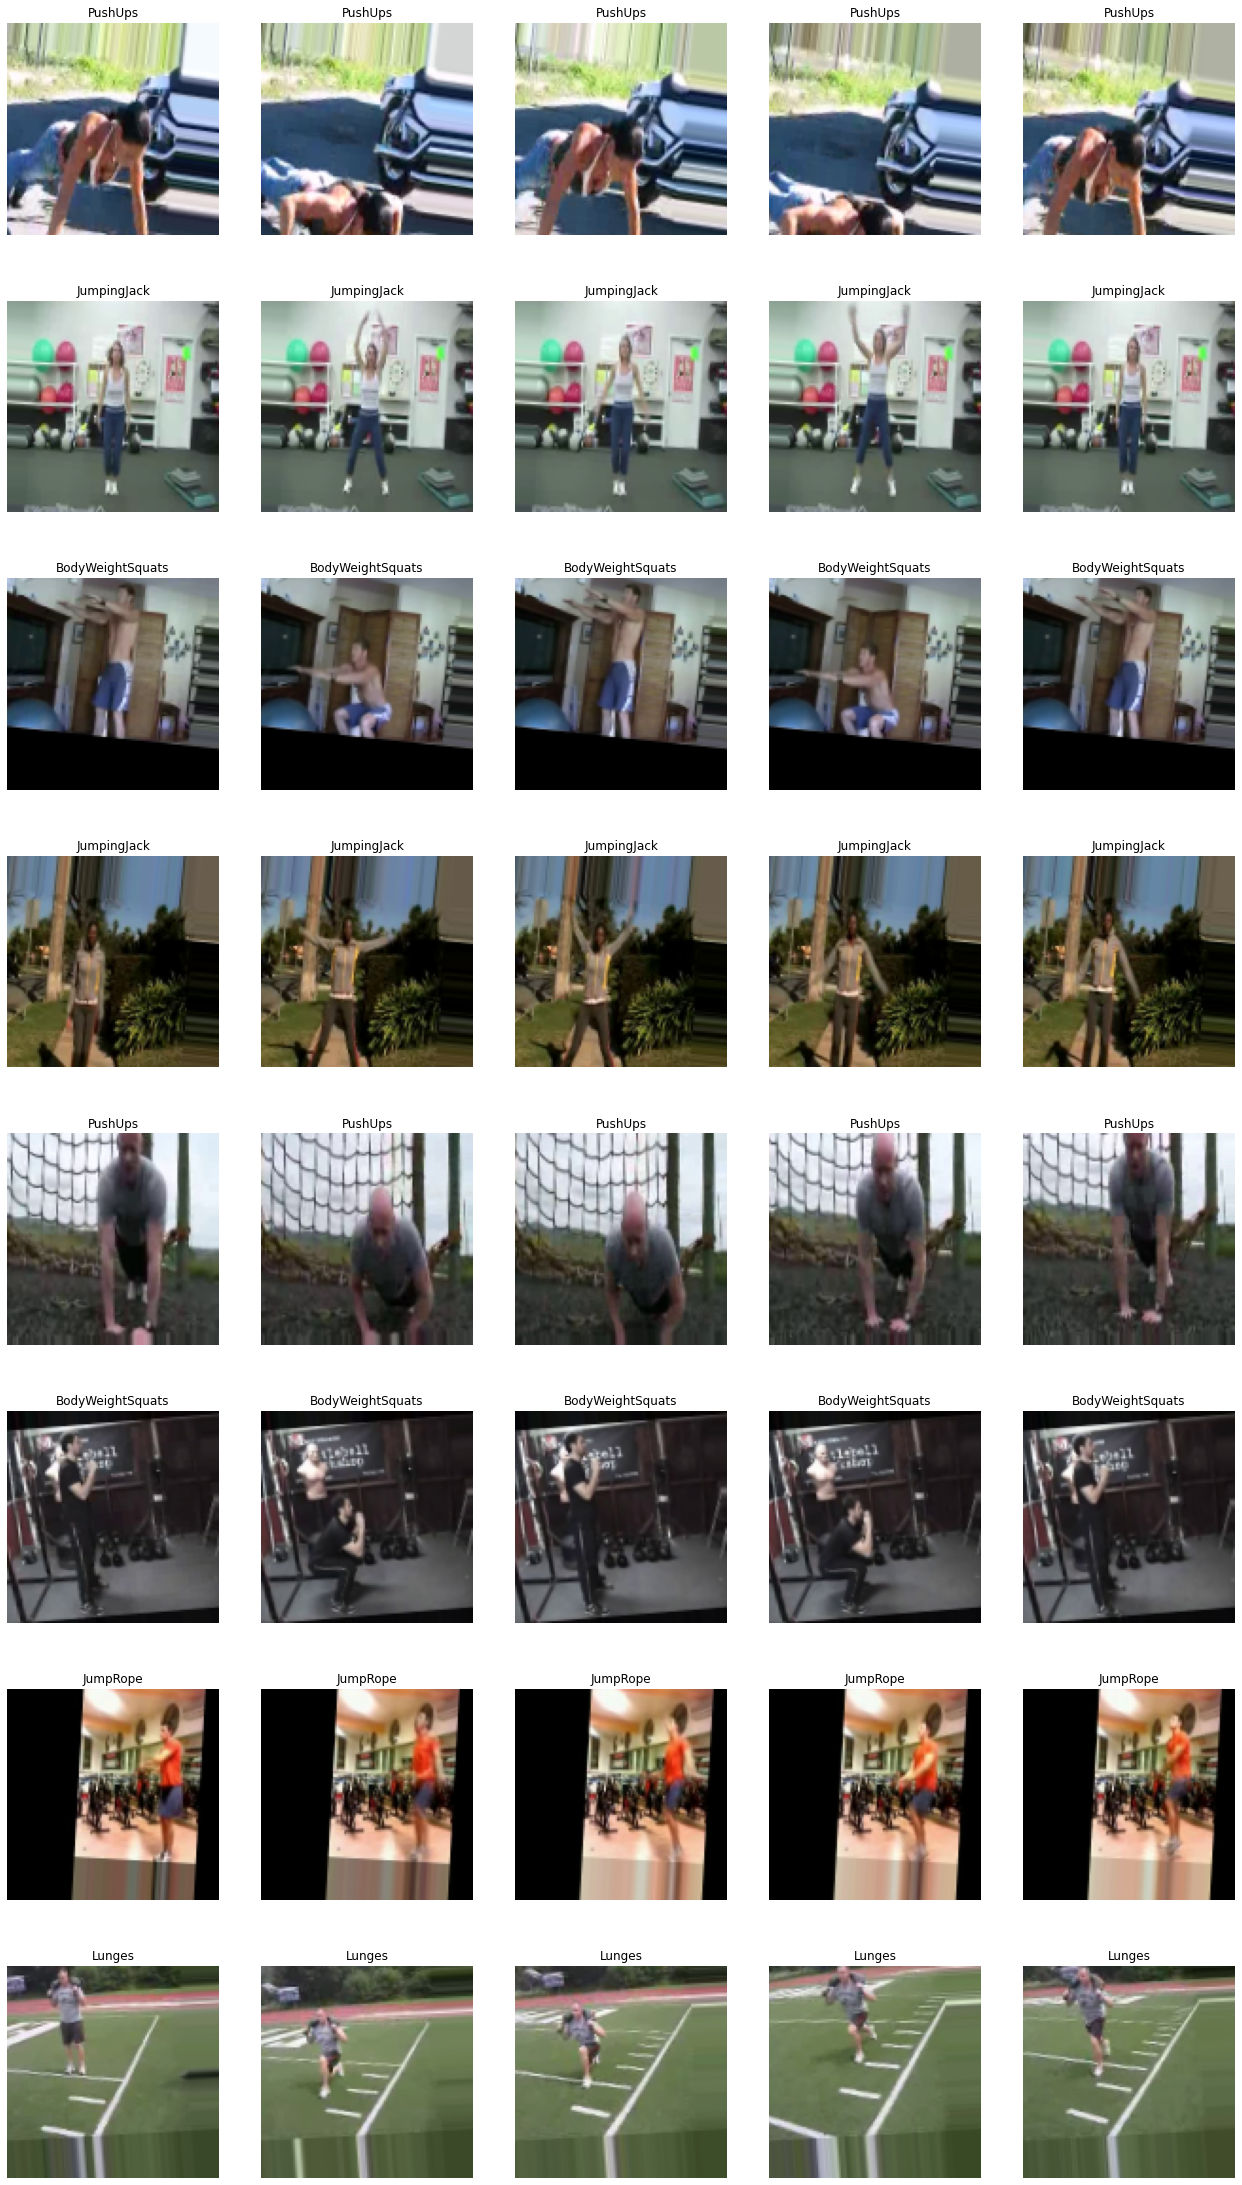

In [ ]:
aimport keras_video.utils
keras_video.utils.show_sample(train)

In [ ]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.00001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
EPOCHS=200
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    shuffle=True,
    use_multiprocessing=True,
    epochs=EPOCHS
)

Epoch 1/200
104/104 [==============================] - 25s 238ms/step - loss: 2.3246 - acc: 0.1226 - val_loss: 2.2942 - val_acc: 0.1025
Epoch 2/200
104/104 [==============================] - 23s 219ms/step - loss: 2.3442 - acc: 0.0986 - val_loss: 2.2898 - val_acc: 0.1050
Epoch 3/200
104/104 [==============================] - 23s 216ms/step - loss: 2.3262 - acc: 0.1262 - val_loss: 2.2889 - val_acc: 0.1300
Epoch 4/200
104/104 [==============================] - 23s 216ms/step - loss: 2.3254 - acc: 0.1046 - val_loss: 2.2873 - val_acc: 0.1200
Epoch 5/200
104/104 [==============================] - 23s 219ms/step - loss: 2.3113 - acc: 0.1058 - val_loss: 2.2811 - val_acc: 0.1950
Epoch 6/200
104/104 [==============================] - 23s 217ms/step - loss: 2.3006 - acc: 0.1442 - val_loss: 2.2756 - val_acc: 0.2500
Epoch 7/200
104/104 [==============================] - 23s 217ms/step - loss: 2.2988 - acc: 0.1250 - val_loss: 2.2725 - val_acc: 0.2300
Epoch 8/200
104/104 [===========================

In [ ]:
 model.save('/content/drive/MyDrive/UCF101-Dataset/model3.h5')